# Exploratory Data Analysis: HTML Fragments - All Schema Types

This notebook provides comprehensive analysis of collected HTML fragments from both candidates and negatives directories:

## Data Sources
- **Candidates** (`data/seeds/candidates/`): Intentionally collected fragments that passed validation
  - Includes: recipe, job_posting, pricing_table, event, person, product, authrequired
- **Negatives** (`data/seeds/negatives/`): Rejected or negative-example fragments
  - Includes: error_page, authrequired, empty_shell, captcha_or_bot_check

## Analysis Coverage
1. **Schema type distribution** - Count and categorization of all schema types
2. **Context window sizing** - Token counts using Qwen2.5-0.5B tokenizer (32k limit)
3. **Text proportion analysis** - Ratio of extracted text to full HTML
4. **Quality metrics** - Token distributions, size distributions across schema types
5. **Positive vs Negative comparison** - Statistical differences
6. **Negative schema deep dive** - Detailed analysis of error_page, authrequired, empty_shell
7. **Authrequired comparison** - Candidates vs negatives (same schema, different collection intent)
8. **Complete schema coverage** - Comprehensive view of all schema types

## Key Insight
Negative schemas (error_page, authrequired, empty_shell) are **valid HTML→JSON extraction examples**, not "bad" data. They represent different content types that are valuable for training a robust extraction model.

**Note**: Token counts use the Qwen2.5-0.5B tokenizer to match the target model for fine-tuning.

## Imports

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter
import sys
from bs4 import BeautifulSoup

# Add project root to path for src imports
sys.path.insert(0, str(Path('..').resolve()))
from src.qwen_utils import count_tokens

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

%matplotlib inline

print('All libraries imported successfully!')
print('Using Qwen2.5-0.5B tokenizer for token counting')

/Users/shuisongluar/projects/c4ai-crawlerlm/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


All libraries imported successfully!
Using Qwen2.5-0.5B tokenizer for token counting


## Load Positive Examples (Candidates)

In [2]:
# Find all positive HTML files
candidates_dir = Path('../data/seeds/candidates')
positive_html_files = sorted(candidates_dir.glob('*.html'))

print(f'Found {len(positive_html_files)} positive HTML files')

# Parse schema types - handle multi-word types like job_posting, pricing_table, authrequired
schema_counts = Counter()
for html_file in positive_html_files:
    parts = html_file.stem.split('_')
    # Check for multi-word schema types
    if parts[0] == 'job' and len(parts) > 1 and parts[1] == 'posting':
        schema_type = 'job_posting'
    elif parts[0] == 'pricing' and len(parts) > 1 and parts[1] == 'table':
        schema_type = 'pricing_table'
    elif parts[0] == 'auth' and len(parts) > 1 and parts[1] == 'required':
        schema_type = 'authrequired'
    else:
        schema_type = parts[0]
    schema_counts[schema_type] += 1

print(f'\nPositive schema type distribution:')
for schema_type, count in schema_counts.most_common():
    print(f'  {schema_type}: {count}')

Found 157 positive HTML files

Positive schema type distribution:
  recipe: 50
  job_posting: 35
  event: 23
  pricing_table: 20
  authrequired: 15
  person: 9
  product: 5


## Load Negative Examples

In [3]:
# Find all negative HTML files
negatives_dir = Path('../data/seeds/negatives')
negative_html_files = sorted(negatives_dir.glob('*.html'))

print(f'Found {len(negative_html_files)} negative HTML files')

# Parse schema types for negatives
# Negatives use descriptive prefixes: errorpage, authrequired, emptyspashell, captcha_or_bot_check
negative_schema_counts = Counter()
for html_file in negative_html_files:
    parts = html_file.stem.split('_')
    # Map negative prefixes to schema types
    if parts[0] == 'errorpage':
        schema_type = 'error_page'
    elif parts[0] == 'authrequired':
        schema_type = 'authrequired'
    elif parts[0] == 'emptyspashell':
        schema_type = 'empty_shell'
    elif parts[0] == 'captcha':
        schema_type = 'captcha_or_bot_check'
    else:
        schema_type = parts[0]
    negative_schema_counts[schema_type] += 1

print(f'\nNegative schema type distribution:')
for schema_type, count in negative_schema_counts.most_common():
    print(f'  {schema_type}: {count}')

Found 14 negative HTML files

Negative schema type distribution:
  error_page: 6
  authrequired: 5
  captcha_or_bot_check: 3


## Analyze Positive Examples

In [4]:
# Analyze each positive HTML fragment
print('Analyzing positive HTML fragments...')
positive_data = []

for i, html_file in enumerate(positive_html_files):
    if (i + 1) % 50 == 0:
        print(f'  Processed {i + 1}/{len(positive_html_files)} files...')
    
    # Parse schema type and ID - handle multi-word types
    parts = html_file.stem.split('_')
    if parts[0] == 'job' and len(parts) > 2 and parts[1] == 'posting':
        schema_type = 'job_posting'
        fragment_id = '_'.join(parts[2:])
    elif parts[0] == 'pricing' and len(parts) > 2 and parts[1] == 'table':
        schema_type = 'pricing_table'
        fragment_id = '_'.join(parts[2:])
    elif parts[0] == 'auth' and len(parts) > 2 and parts[1] == 'required':
        schema_type = 'authrequired'
        fragment_id = '_'.join(parts[2:])
    else:
        schema_type = parts[0]
        fragment_id = '_'.join(parts[1:])
    
    # Read HTML
    with open(html_file, 'r', encoding='utf-8', errors='replace') as f:
        html = f.read()
    
    # Extract text using BeautifulSoup
    soup = BeautifulSoup(html, 'html.parser')
    extracted_text = soup.get_text(separator=' ', strip=True)
    
    # Token counts using Qwen tokenizer
    html_tokens = count_tokens(html)
    text_tokens = count_tokens(extracted_text)
    
    # Character counts
    html_chars = len(html)
    text_chars = len(extracted_text)
    
    # Text proportion (chars)
    text_proportion = text_chars / html_chars if html_chars > 0 else 0
    
    # Load metadata if available
    metadata_file = html_file.with_suffix('.json')
    validation_score = None
    if metadata_file.exists():
        with open(metadata_file, 'r') as f:
            metadata = json.load(f)
            validation_score = metadata.get('validation', {}).get('score')
    
    positive_data.append({
        'file': html_file.name,
        'schema_type': schema_type,
        'fragment_id': fragment_id,
        'html_tokens': html_tokens,
        'text_tokens': text_tokens,
        'html_chars': html_chars,
        'text_chars': text_chars,
        'text_proportion': text_proportion,
        'tokens_per_char': html_tokens / html_chars if html_chars > 0 else 0,
        'validation_score': validation_score,
        'label': 'positive'
    })

df_positive = pd.DataFrame(positive_data)

print(f'\nAnalysis complete for {len(df_positive)} positive fragments')
print(f'DataFrame shape: {df_positive.shape}')
df_positive.head()

Analyzing positive HTML fragments...


Token indices sequence length is longer than the specified maximum sequence length for this model (249317 > 131072). Running this sequence through the model will result in indexing errors


  Processed 50/157 files...
  Processed 100/157 files...
  Processed 150/157 files...

Analysis complete for 157 positive fragments
DataFrame shape: (157, 11)


,file,schema_type,fragment_id,html_tokens,text_tokens,html_chars,text_chars,text_proportion,tokens_per_char,validation_score,label
0,auth_required_3c824d95.html,authrequired,3c824d95,249317,1640,397197,8773,0.022087,0.627691,0.5,positive
1,auth_required_3cd6844b.html,authrequired,3cd6844b,16620,0,22675,0,0.000000,0.732966,0.5,positive
2,auth_required_3edd0904.html,authrequired,3edd0904,16621,0,22676,0,0.000000,0.732978,0.5,positive
3,auth_required_6bd499bf.html,authrequired,6bd499bf,12265,279,22473,732,0.032572,0.545766,0.5,positive
4,auth_required_6dad0016.html,authrequired,6dad0016,4061,57,8543,267,0.031254,0.475360,0.5,positive


## Analyze Negative Examples

In [5]:
# Analyze each negative HTML fragment
print('Analyzing negative HTML fragments...')
negative_data = []

for i, html_file in enumerate(negative_html_files):
    if (i + 1) % 10 == 0:
        print(f'  Processed {i + 1}/{len(negative_html_files)} files...')
    
    # Parse schema type and ID - map prefixes to schema types
    parts = html_file.stem.split('_')
    if parts[0] == 'errorpage':
        schema_type = 'error_page'
        fragment_id = '_'.join(parts[1:])
    elif parts[0] == 'authrequired':
        schema_type = 'authrequired'
        fragment_id = '_'.join(parts[1:])
    elif parts[0] == 'emptyspashell':
        schema_type = 'empty_shell'
        fragment_id = '_'.join(parts[1:])
    elif parts[0] == 'captcha':
        schema_type = 'captcha_or_bot_check'
        fragment_id = '_'.join(parts[1:])
    else:
        schema_type = parts[0]
        fragment_id = '_'.join(parts[1:])
    
    # Read HTML
    with open(html_file, 'r', encoding='utf-8', errors='replace') as f:
        html = f.read()
    
    # Extract text using BeautifulSoup
    soup = BeautifulSoup(html, 'html.parser')
    extracted_text = soup.get_text(separator=' ', strip=True)
    
    # Token counts using Qwen tokenizer
    html_tokens = count_tokens(html)
    text_tokens = count_tokens(extracted_text)
    
    # Character counts
    html_chars = len(html)
    text_chars = len(extracted_text)
    
    # Text proportion (chars)
    text_proportion = text_chars / html_chars if html_chars > 0 else 0
    
    # Load metadata (rejection reason, validation score, negative_type)
    metadata_file = html_file.with_suffix('.json')
    rejection_reason = None
    validation_score = None
    negative_type = None
    expected_type = None
    
    if metadata_file.exists():
        with open(metadata_file, 'r') as f:
            metadata = json.load(f)
            rejection_reason = metadata.get('rejection_reason')
            negative_type = metadata.get('negative_type')
            expected_type = metadata.get('expected_type')
            validation = metadata.get('validation', {})
            validation_score = validation.get('score')
    
    negative_data.append({
        'file': html_file.name,
        'schema_type': schema_type,
        'fragment_id': fragment_id,
        'html_tokens': html_tokens,
        'text_tokens': text_tokens,
        'html_chars': html_chars,
        'text_chars': text_chars,
        'text_proportion': text_proportion,
        'tokens_per_char': html_tokens / html_chars if html_chars > 0 else 0,
        'validation_score': validation_score,
        'rejection_reason': rejection_reason,
        'negative_type': negative_type,
        'expected_type': expected_type,
        'label': 'negative'
    })

df_negative = pd.DataFrame(negative_data)

print(f'\nAnalysis complete for {len(df_negative)} negative fragments')
print(f'DataFrame shape: {df_negative.shape}')
df_negative.head()

Analyzing negative HTML fragments...
  Processed 10/14 files...

Analysis complete for 14 negative fragments
DataFrame shape: (14, 14)


,file,schema_type,fragment_id,html_tokens,text_tokens,html_chars,text_chars,text_proportion,tokens_per_char,validation_score,rejection_reason,negative_type,expected_type,label
0,authrequired_72c6fbf5.html,authrequired,72c6fbf5,16176,310,28829,889,0.030837,0.561102,0.0,Detected auth_required: 4/15 negative patterns...,auth_required,auth_required,negative
1,authrequired_aeee151f.html,authrequired,aeee151f,7989,115,18751,587,0.031305,0.426057,0.0,Detected auth_required: 3/15 negative patterns...,auth_required,auth_required,negative
2,authrequired_cc61f442.html,authrequired,cc61f442,18994,399,40049,1344,0.033559,0.474269,0.0,Detected auth_required: 4/15 negative patterns...,auth_required,auth_required,negative
3,authrequired_d74042d1.html,authrequired,d74042d1,39884,1166,128387,5158,0.040175,0.310655,0.0,Detected auth_required: 3/15 negative patterns...,auth_required,auth_required,negative
4,authrequired_d81fdf51.html,authrequired,d81fdf51,19050,399,40272,1344,0.033373,0.473033,0.0,Detected auth_required: 4/15 negative patterns...,auth_required,auth_required,negative


## Rejection Reason Analysis

In [6]:
# Analyze rejection reasons
print('Rejection Reason Analysis:')
print('=' * 70)

# Count by rejection reason
rejection_counts = df_negative['rejection_reason'].value_counts()
print(f'\nRejection reasons (total: {len(df_negative)}):')
for reason, count in rejection_counts.items():
    print(f'  {reason}: {count}')

# Count by negative type
print(f'\nNegative type classification:')
negative_type_counts = df_negative['negative_type'].value_counts()
for neg_type, count in negative_type_counts.items():
    print(f'  {neg_type}: {count}')

# Count by expected type (what was being collected when this was rejected)
if 'expected_type' in df_negative.columns and df_negative['expected_type'].notna().any():
    print(f'\nExpected types (what was being collected):')
    expected_counts = df_negative['expected_type'].value_counts()
    for exp_type, count in expected_counts.items():
        print(f'  {exp_type}: {count}')

# Validation scores for negatives
print(f'\nNegative validation scores:')
print(f'  Mean: {df_negative["validation_score"].mean():.3f}')
print(f'  Median: {df_negative["validation_score"].median():.3f}')
print(f'  Range: {df_negative["validation_score"].min():.3f} - {df_negative["validation_score"].max():.3f}')

# Show examples by schema type
print(f'\nExample files by schema type:')
for schema_type in df_negative['schema_type'].unique():
    subset = df_negative[df_negative['schema_type'] == schema_type]
    print(f'\n  {schema_type} ({len(subset)} examples):')
    for file in subset['file'].head(2):
        print(f'    • {file}')

Rejection Reason Analysis:

Rejection reasons (total: 14):
  Detected error_page: 3/12 negative patterns matched: 4
  Detected auth_required: 4/15 negative patterns matched: 3
  CAPTCHA/bot check page (DataDome iframe): 3
  Detected auth_required: 3/15 negative patterns matched: 2
  Detected error_page: 4/12 negative patterns matched: 1
  Detected error_page: 4/15 negative patterns matched: 1

Negative type classification:
  error_page: 6
  auth_required: 5
  captcha_or_bot_check: 3

Expected types (what was being collected):
  auth_required: 8
  spa_heavy: 3

Negative validation scores:
  Mean: 0.000
  Median: 0.000
  Range: 0.000 - 0.000

Example files by schema type:

  authrequired (5 examples):
    • authrequired_72c6fbf5.html
    • authrequired_aeee151f.html

  captcha_or_bot_check (3 examples):
    • captcha_or_bot_check_4bd238bc.html
    • captcha_or_bot_check_e58a35da.html

  error_page (6 examples):
    • errorpage_00f5d119.html
    • errorpage_05bca3d5.html


## Detailed Negative Schema Analysis

Deep dive into each negative schema type to understand their characteristics and patterns.

In [7]:
# Analyze each negative schema type in detail
print('NEGATIVE SCHEMA TYPE ANALYSIS')
print('=' * 70)

for schema_type in df_negative['schema_type'].unique():
    subset = df_negative[df_negative['schema_type'] == schema_type]
    count = len(subset)
    
    print(f'\n{schema_type.upper()} ({count} examples)')
    print('-' * 70)
    
    # Token statistics
    print(f'Token count:')
    print(f'  Mean: {subset["html_tokens"].mean():,.0f}')
    print(f'  Median: {subset["html_tokens"].median():,.0f}')
    print(f'  Range: {subset["html_tokens"].min():,.0f} - {subset["html_tokens"].max():,.0f}')
    
    # Text proportion
    print(f'\nText proportion:')
    print(f'  Mean: {subset["text_proportion"].mean():.3f}')
    print(f'  Median: {subset["text_proportion"].median():.3f}')
    
    # Expected types (what they were supposed to be before rejection)
    if 'expected_type' in subset.columns and subset['expected_type'].notna().any():
        expected_counts = subset['expected_type'].value_counts()
        print(f'\nExpected types (what was being collected):')
        for exp_type, exp_count in expected_counts.items():
            print(f'  {exp_type}: {exp_count}')
    
    # Rejection reasons
    if 'rejection_reason' in subset.columns and subset['rejection_reason'].notna().any():
        print(f'\nRejection reasons:')
        for reason in subset['rejection_reason'].unique():
            if pd.notna(reason):
                print(f'  • {reason}')
    
    # Show example files
    print(f'\nExample files:')
    for file in subset['file'].head(3):
        print(f'  • {file}')

NEGATIVE SCHEMA TYPE ANALYSIS

AUTHREQUIRED (5 examples)
----------------------------------------------------------------------
Token count:
  Mean: 20,419
  Median: 18,994
  Range: 7,989 - 39,884

Text proportion:
  Mean: 0.034
  Median: 0.033

Expected types (what was being collected):
  auth_required: 5

Rejection reasons:
  • Detected auth_required: 4/15 negative patterns matched
  • Detected auth_required: 3/15 negative patterns matched

Example files:
  • authrequired_72c6fbf5.html
  • authrequired_aeee151f.html
  • authrequired_cc61f442.html

CAPTCHA_OR_BOT_CHECK (3 examples)
----------------------------------------------------------------------
Token count:
  Mean: 392
  Median: 394
  Range: 388 - 394

Text proportion:
  Mean: 0.000
  Median: 0.000

Rejection reasons:
  • CAPTCHA/bot check page (DataDome iframe)

Example files:
  • captcha_or_bot_check_4bd238bc.html
  • captcha_or_bot_check_e58a35da.html
  • captcha_or_bot_check_ee2bf0b3.html

ERROR_PAGE (6 examples)
----------

## Authrequired: Candidates vs Negatives Comparison

Compare authrequired examples in candidates (intentionally collected) vs negatives (accidentally encountered).

AUTHREQUIRED COMPARISON: Candidates vs Negatives

Candidates (intentionally collected): 15 examples
Negatives (accidentally encountered): 5 examples
Total authrequired examples: 20

Statistical Comparison:
                       Candidates  Negatives
Count                       15.00       5.00
Mean tokens              27546.87   20418.60
Median tokens             8949.00   18994.00
Mean text proportion         0.05       0.03
Mean validation score        0.50       0.00


Key Insight:
Both candidates and negatives are valid authrequired examples - the only
difference is collection intent (deliberate vs accidental). From a training
perspective, they are equally valuable HTML→JSON extraction examples.


/var/folders/1w/z8pl8pp51_vbfkfhs3pzkfpc0000gn/T/ipykernel_28172/1011501856.py:42: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot([authrequired_positive['html_tokens'], authrequired_negative['html_tokens']],
/var/folders/1w/z8pl8pp51_vbfkfhs3pzkfpc0000gn/T/ipykernel_28172/1011501856.py:49: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot([authrequired_positive['text_proportion'], authrequired_negative['text_proportion']],


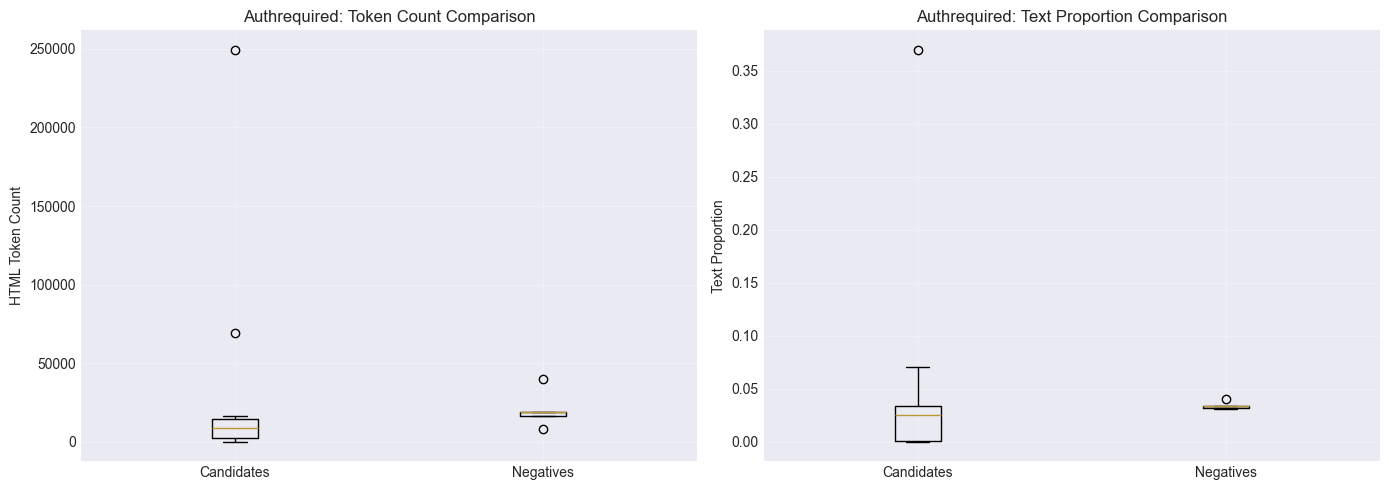

In [8]:
# Compare authrequired examples between candidates and negatives
authrequired_positive = df_positive[df_positive['schema_type'] == 'authrequired']
authrequired_negative = df_negative[df_negative['schema_type'] == 'authrequired']

print('AUTHREQUIRED COMPARISON: Candidates vs Negatives')
print('=' * 70)

print(f'\nCandidates (intentionally collected): {len(authrequired_positive)} examples')
print(f'Negatives (accidentally encountered): {len(authrequired_negative)} examples')
print(f'Total authrequired examples: {len(authrequired_positive) + len(authrequired_negative)}')

# Compare statistics
comparison_df = pd.DataFrame({
    'Candidates': [
        len(authrequired_positive),
        authrequired_positive['html_tokens'].mean(),
        authrequired_positive['html_tokens'].median(),
        authrequired_positive['text_proportion'].mean(),
        authrequired_positive['validation_score'].mean() if 'validation_score' in authrequired_positive.columns else None,
    ],
    'Negatives': [
        len(authrequired_negative),
        authrequired_negative['html_tokens'].mean(),
        authrequired_negative['html_tokens'].median(),
        authrequired_negative['text_proportion'].mean(),
        authrequired_negative['validation_score'].mean() if 'validation_score' in authrequired_negative.columns else None,
    ]
}, index=['Count', 'Mean tokens', 'Median tokens', 'Mean text proportion', 'Mean validation score'])

print('\nStatistical Comparison:')
print(comparison_df.round(2))

print('\n\nKey Insight:')
print('Both candidates and negatives are valid authrequired examples - the only')
print('difference is collection intent (deliberate vs accidental). From a training')
print('perspective, they are equally valuable HTML→JSON extraction examples.')

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Token count comparison
axes[0].boxplot([authrequired_positive['html_tokens'], authrequired_negative['html_tokens']], 
                labels=['Candidates', 'Negatives'])
axes[0].set_ylabel('HTML Token Count')
axes[0].set_title('Authrequired: Token Count Comparison')
axes[0].grid(True, alpha=0.3)

# Text proportion comparison
axes[1].boxplot([authrequired_positive['text_proportion'], authrequired_negative['text_proportion']], 
                labels=['Candidates', 'Negatives'])
axes[1].set_ylabel('Text Proportion')
axes[1].set_title('Authrequired: Text Proportion Comparison')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Combine Datasets for Comparison

In [9]:
# Combine positive and negative dataframes
# Note: negatives have extra columns (rejection_reason, found_fields, missing_fields)
df_combined = pd.concat([df_positive, df_negative], ignore_index=True)

print(f'Combined dataset: {len(df_combined)} total fragments')
print(f'  Positive: {len(df_positive)} ({len(df_positive)/len(df_combined)*100:.1f}%)')
print(f'  Negative: {len(df_negative)} ({len(df_negative)/len(df_combined)*100:.1f}%)')

df_combined.head()

Combined dataset: 171 total fragments
  Positive: 157 (91.8%)
  Negative: 14 (8.2%)


,file,schema_type,fragment_id,html_tokens,text_tokens,html_chars,text_chars,text_proportion,tokens_per_char,validation_score,label,rejection_reason,negative_type,expected_type
0,auth_required_3c824d95.html,authrequired,3c824d95,249317,1640,397197,8773,0.022087,0.627691,0.5,positive,NaN,NaN,NaN
1,auth_required_3cd6844b.html,authrequired,3cd6844b,16620,0,22675,0,0.000000,0.732966,0.5,positive,NaN,NaN,NaN
2,auth_required_3edd0904.html,authrequired,3edd0904,16621,0,22676,0,0.000000,0.732978,0.5,positive,NaN,NaN,NaN
3,auth_required_6bd499bf.html,authrequired,6bd499bf,12265,279,22473,732,0.032572,0.545766,0.5,positive,NaN,NaN,NaN
4,auth_required_6dad0016.html,authrequired,6dad0016,4061,57,8543,267,0.031254,0.475360,0.5,positive,NaN,NaN,NaN


## Positive vs Negative Comparison

In [10]:
# Compare statistics between positive and negative
comparison = df_combined.groupby('label').agg({
    'html_tokens': ['count', 'mean', 'median', 'min', 'max'],
    'text_proportion': ['mean', 'median'],
    'validation_score': ['mean', 'median'],
    'html_chars': ['mean', 'median']
}).round(2)

print('Positive vs Negative Comparison:')
print('=' * 70)
print(comparison)
print('\nKey observations:')
print(f"  Negative examples have {'higher' if df_negative['html_tokens'].mean() > df_positive['html_tokens'].mean() else 'lower'} mean token count")
print(f"  Negative examples have {'higher' if df_negative['text_proportion'].mean() > df_positive['text_proportion'].mean() else 'lower'} mean text proportion")
print(f"  Negative examples have {'higher' if df_negative['validation_score'].mean() > df_positive['validation_score'].mean() else 'lower'} mean validation score")

Positive vs Negative Comparison:
         html_tokens                                 text_proportion         \
               count      mean   median  min     max            mean median   
label                                                                         
negative          14  13641.50   3532.0  388   79406            0.07   0.03   
positive         157  33592.01  18057.0  139  249317            0.11   0.08   

         validation_score        html_chars           
                     mean median       mean   median  
label                                                 
negative             0.00    0.0   35479.07  10657.0  
positive             0.63    0.6   82555.22  49082.0  

Key observations:
  Negative examples have lower mean token count
  Negative examples have lower mean text proportion
  Negative examples have lower mean validation score


## Visualization: Positive vs Negative

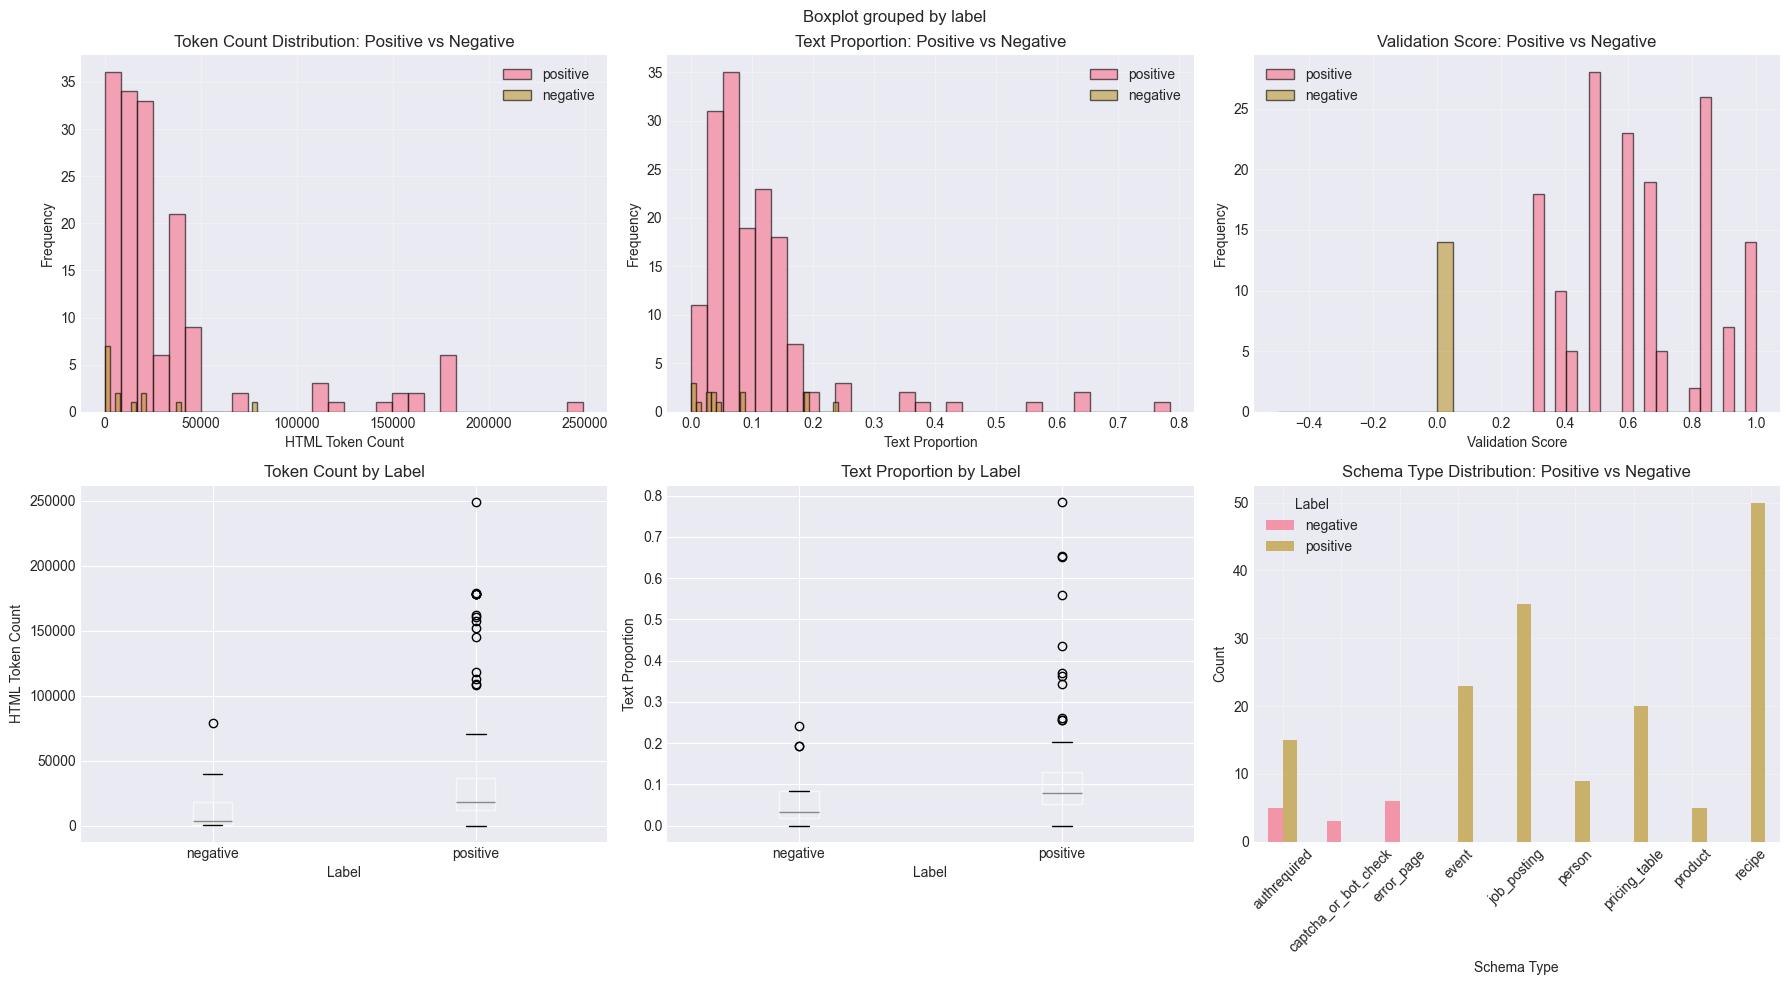

In [11]:
# Create comparison visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Token count distribution by label
for label in ['positive', 'negative']:
    subset = df_combined[df_combined['label'] == label]
    axes[0, 0].hist(subset['html_tokens'], bins=30, alpha=0.6, label=label, edgecolor='black')
axes[0, 0].set_xlabel('HTML Token Count')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Token Count Distribution: Positive vs Negative')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Text proportion distribution by label
for label in ['positive', 'negative']:
    subset = df_combined[df_combined['label'] == label]
    axes[0, 1].hist(subset['text_proportion'], bins=30, alpha=0.6, label=label, edgecolor='black')
axes[0, 1].set_xlabel('Text Proportion')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Text Proportion: Positive vs Negative')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Validation score distribution by label
for label in ['positive', 'negative']:
    subset = df_combined[df_combined['label'] == label]
    axes[0, 2].hist(subset['validation_score'].dropna(), bins=20, alpha=0.6, label=label, edgecolor='black')
axes[0, 2].set_xlabel('Validation Score')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].set_title('Validation Score: Positive vs Negative')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# 4. Box plot: token count by label
df_combined.boxplot(column='html_tokens', by='label', ax=axes[1, 0])
axes[1, 0].set_xlabel('Label')
axes[1, 0].set_ylabel('HTML Token Count')
axes[1, 0].set_title('Token Count by Label')
plt.sca(axes[1, 0])
plt.xticks(rotation=0)

# 5. Box plot: text proportion by label
df_combined.boxplot(column='text_proportion', by='label', ax=axes[1, 1])
axes[1, 1].set_xlabel('Label')
axes[1, 1].set_ylabel('Text Proportion')
axes[1, 1].set_title('Text Proportion by Label')
plt.sca(axes[1, 1])
plt.xticks(rotation=0)

# 6. Schema type distribution: positive vs negative
schema_label_counts = df_combined.groupby(['schema_type', 'label']).size().unstack(fill_value=0)
schema_label_counts.plot(kind='bar', ax=axes[1, 2], alpha=0.7)
axes[1, 2].set_xlabel('Schema Type')
axes[1, 2].set_ylabel('Count')
axes[1, 2].set_title('Schema Type Distribution: Positive vs Negative')
axes[1, 2].legend(title='Label')
axes[1, 2].grid(True, alpha=0.3)
plt.sca(axes[1, 2])
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## Token Count Analysis (Positive Examples Only)

In [12]:
# Focus on positive examples for training data quality
df = df_positive.copy()

# Summary statistics
print('Positive HTML Token Count Statistics (Qwen2.5-0.5B tokenizer):')
print(f'  Min: {df["html_tokens"].min():,} tokens')
print(f'  Max: {df["html_tokens"].max():,} tokens')
print(f'  Mean: {df["html_tokens"].mean():,.0f} tokens')
print(f'  Median: {df["html_tokens"].median():,.0f} tokens')
print(f'  25th percentile: {df["html_tokens"].quantile(0.25):,.0f} tokens')
print(f'  75th percentile: {df["html_tokens"].quantile(0.75):,.0f} tokens')

# Context window limits
print(f'\nContext Window Fit Analysis:')
context_limits = {
    '8K': 8192,
    '16K': 16384,
    '24K': 24576,
    '32K': 32768,
}

for name, limit in context_limits.items():
    within = (df['html_tokens'] <= limit).sum()
    pct = within / len(df) * 100
    print(f'  Within {name} ({limit:,} tokens): {within}/{len(df)} ({pct:.1f}%)')

# Preferred range (<24k)
preferred = (df['html_tokens'] <= 24576).sum()
preferred_pct = preferred / len(df) * 100
print(f'\n  In preferred range (8K-24K): {preferred}/{len(df)} ({preferred_pct:.1f}%)')

Positive HTML Token Count Statistics (Qwen2.5-0.5B tokenizer):
  Min: 139 tokens
  Max: 249,317 tokens
  Mean: 33,592 tokens
  Median: 18,057 tokens
  25th percentile: 11,827 tokens
  75th percentile: 37,016 tokens

Context Window Fit Analysis:
  Within 8K (8,192 tokens): 35/157 (22.3%)
  Within 16K (16,384 tokens): 66/157 (42.0%)
  Within 24K (24,576 tokens): 102/157 (65.0%)
  Within 32K (32,768 tokens): 109/157 (69.4%)

  In preferred range (8K-24K): 102/157 (65.0%)


## Visualize Positive Token Distribution

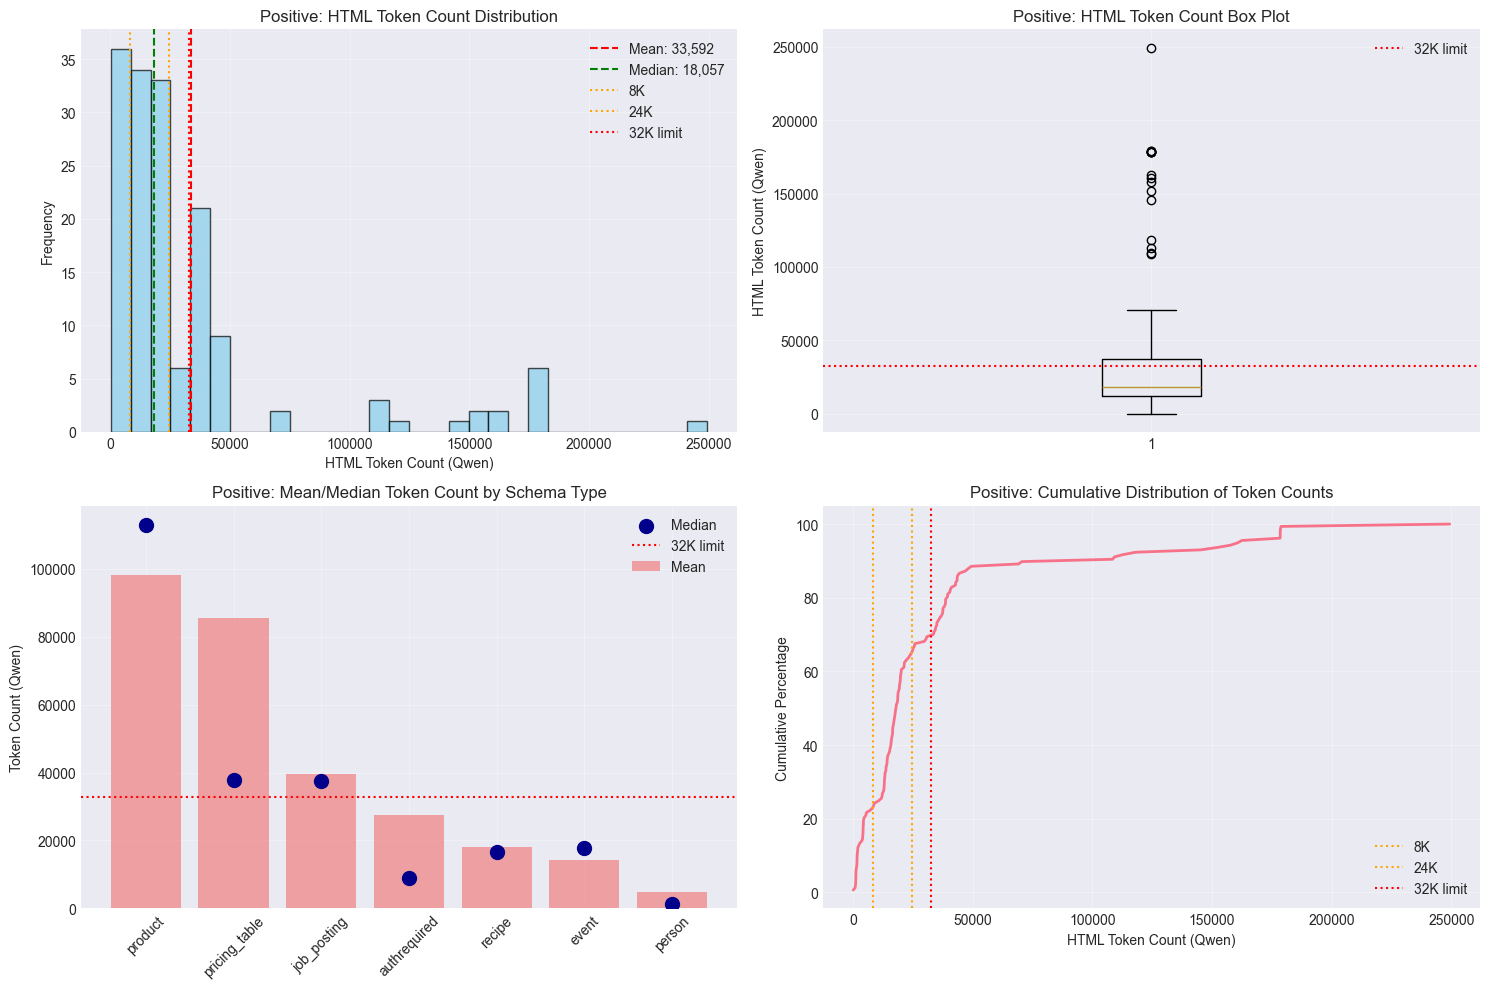

In [13]:
# Visualize token distribution for positives
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Histogram
axes[0, 0].hist(df['html_tokens'], bins=30, edgecolor='black', alpha=0.7, color='skyblue')
axes[0, 0].axvline(df['html_tokens'].mean(), color='red', linestyle='--', 
                   label=f'Mean: {df["html_tokens"].mean():,.0f}')
axes[0, 0].axvline(df['html_tokens'].median(), color='green', linestyle='--', 
                   label=f'Median: {df["html_tokens"].median():,.0f}')
axes[0, 0].axvline(8192, color='orange', linestyle=':', label='8K')
axes[0, 0].axvline(24576, color='orange', linestyle=':', label='24K')
axes[0, 0].axvline(32768, color='red', linestyle=':', label='32K limit')
axes[0, 0].set_xlabel('HTML Token Count (Qwen)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Positive: HTML Token Count Distribution')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Box plot
axes[0, 1].boxplot(df['html_tokens'], vert=True)
axes[0, 1].set_ylabel('HTML Token Count (Qwen)')
axes[0, 1].set_title('Positive: HTML Token Count Box Plot')
axes[0, 1].axhline(32768, color='red', linestyle=':', label='32K limit')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()

# By schema type
schema_tokens = df.groupby('schema_type')['html_tokens'].agg(['mean', 'median', 'min', 'max'])
schema_tokens = schema_tokens.sort_values('mean', ascending=False)
x_pos = np.arange(len(schema_tokens))
axes[1, 0].bar(x_pos, schema_tokens['mean'], color='lightcoral', alpha=0.7, label='Mean')
axes[1, 0].scatter(x_pos, schema_tokens['median'], color='darkblue', s=100, zorder=3, label='Median')
axes[1, 0].axhline(32768, color='red', linestyle=':', label='32K limit')
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels(schema_tokens.index, rotation=45)
axes[1, 0].set_ylabel('Token Count (Qwen)')
axes[1, 0].set_title('Positive: Mean/Median Token Count by Schema Type')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Cumulative distribution
sorted_tokens = np.sort(df['html_tokens'])
cumulative = np.arange(1, len(sorted_tokens) + 1) / len(sorted_tokens) * 100
axes[1, 1].plot(sorted_tokens, cumulative, linewidth=2)
axes[1, 1].axvline(8192, color='orange', linestyle=':', label='8K')
axes[1, 1].axvline(24576, color='orange', linestyle=':', label='24K')
axes[1, 1].axvline(32768, color='red', linestyle=':', label='32K limit')
axes[1, 1].set_xlabel('HTML Token Count (Qwen)')
axes[1, 1].set_ylabel('Cumulative Percentage')
axes[1, 1].set_title('Positive: Cumulative Distribution of Token Counts')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Text Proportion Analysis (Positive Examples)

In [14]:
# Summary statistics for text proportion
print('Positive Text Proportion Statistics (text_chars / html_chars):')
print(f'  Min: {df["text_proportion"].min():.3f}')
print(f'  Max: {df["text_proportion"].max():.3f}')
print(f'  Mean: {df["text_proportion"].mean():.3f}')
print(f'  Median: {df["text_proportion"].median():.3f}')
print(f'  25th percentile: {df["text_proportion"].quantile(0.25):.3f}')
print(f'  75th percentile: {df["text_proportion"].quantile(0.75):.3f}')

# By schema type
print(f'\nText Proportion by Schema Type (Positive):')
schema_text_prop = df.groupby('schema_type')['text_proportion'].agg(['mean', 'median', 'min', 'max'])
schema_text_prop = schema_text_prop.sort_values('mean', ascending=False)
print(schema_text_prop.round(3))

Positive Text Proportion Statistics (text_chars / html_chars):
  Min: 0.000
  Max: 0.785
  Mean: 0.109
  Median: 0.080
  25th percentile: 0.052
  75th percentile: 0.129

Text Proportion by Schema Type (Positive):
                mean  median    min    max
schema_type                               
person         0.416   0.363  0.114  0.785
recipe         0.113   0.122  0.028  0.204
job_posting    0.112   0.091  0.017  0.437
event          0.067   0.058  0.017  0.112
pricing_table  0.066   0.058  0.036  0.136
product        0.062   0.050  0.046  0.105
authrequired   0.045   0.025  0.000  0.370


## Schema Type Comparison (Positive Examples)

In [15]:
# Summary table by schema type
summary_by_schema = df.groupby('schema_type').agg({
    'html_tokens': ['count', 'mean', 'median', 'min', 'max'],
    'text_proportion': ['mean', 'median'],
    'html_chars': ['mean', 'median']
}).round(2)

print('Positive Summary Statistics by Schema Type:\n')
print(summary_by_schema)

Positive Summary Statistics by Schema Type:

              html_tokens                                    text_proportion  \
                    count      mean    median    min     max            mean   
schema_type                                                                    
authrequired           15  27546.87    8949.0    139  249317            0.05   
event                  23  14387.39   17898.0   1577   40698            0.07   
job_posting            35  39638.94   37600.0   4206  152051            0.11   
person                  9   4960.22    1270.0   1175   24428            0.42   
pricing_table          20  85400.60   37754.5    921  178853            0.07   
product                 5  98099.40  112955.0  43537  145246            0.06   
recipe                 50  17986.36   16706.0   2482   43527            0.11   

                     html_chars            
              median       mean    median  
schema_type                                
authrequired    0.02  

In [16]:
# Detailed table showing context window fit by schema type
context_fit_by_schema = []

for schema_type in df['schema_type'].unique():
    subset = df[df['schema_type'] == schema_type]
    total = len(subset)
    
    within_8k = (subset['html_tokens'] <= 8192).sum()
    within_16k = (subset['html_tokens'] <= 16384).sum()
    within_24k = (subset['html_tokens'] <= 24576).sum()
    within_32k = (subset['html_tokens'] <= 32768).sum()
    in_preferred = (subset['html_tokens'] <= 24576).sum()
    
    context_fit_by_schema.append({
        'schema_type': schema_type,
        'total': total,
        '≤8K': f"{within_8k} ({within_8k/total*100:.1f}%)",
        '≤16K': f"{within_16k} ({within_16k/total*100:.1f}%)",
        '≤24K': f"{within_24k} ({within_24k/total*100:.1f}%)",
        '≤32K': f"{within_32k} ({within_32k/total*100:.1f}%)",
        '8K-24K': f"{in_preferred} ({in_preferred/total*100:.1f}%)"
    })

context_fit_df = pd.DataFrame(context_fit_by_schema)
print('\nPositive Context Window Fit by Schema Type:\n')
print(context_fit_df.to_string(index=False))


Positive Context Window Fit by Schema Type:

  schema_type  total       ≤8K       ≤16K       ≤24K       ≤32K     8K-24K
 authrequired     15 7 (46.7%) 11 (73.3%) 13 (86.7%) 13 (86.7%) 13 (86.7%)
        event     23 8 (34.8%)  9 (39.1%) 21 (91.3%) 22 (95.7%) 21 (91.3%)
  job_posting     35 5 (14.3%)  7 (20.0%)  7 (20.0%) 10 (28.6%)  7 (20.0%)
       person      9 7 (77.8%)  8 (88.9%) 9 (100.0%) 9 (100.0%) 9 (100.0%)
pricing_table     20 7 (35.0%)  8 (40.0%)  8 (40.0%)  8 (40.0%)  8 (40.0%)
      product      5  0 (0.0%)   0 (0.0%)   0 (0.0%)   0 (0.0%)   0 (0.0%)
       recipe     50  1 (2.0%) 23 (46.0%) 44 (88.0%) 47 (94.0%) 44 (88.0%)


## Export Analysis Results

## Complete Schema Type Coverage

Comprehensive analysis of all schema types currently in the dataset, including newly added types.

In [17]:
# Get all unique schema types across both datasets
all_schema_types = sorted(set(df_positive['schema_type'].unique()) | set(df_negative['schema_type'].unique()))

print('ALL SCHEMA TYPES IN DATASET')
print('=' * 70)
print(f'\nTotal unique schema types: {len(all_schema_types)}')
print(f'\nSchema types: {", ".join(all_schema_types)}')

# Create comprehensive summary table
summary_data = []
for schema_type in all_schema_types:
    positive_count = len(df_positive[df_positive['schema_type'] == schema_type])
    negative_count = len(df_negative[df_negative['schema_type'] == schema_type])
    total_count = positive_count + negative_count
    
    # Get combined stats
    combined_subset = df_combined[df_combined['schema_type'] == schema_type]
    
    summary_data.append({
        'schema_type': schema_type,
        'positive': positive_count,
        'negative': negative_count,
        'total': total_count,
        'mean_tokens': combined_subset['html_tokens'].mean(),
        'median_tokens': combined_subset['html_tokens'].median(),
        'mean_text_prop': combined_subset['text_proportion'].mean(),
    })

summary_table = pd.DataFrame(summary_data)
summary_table = summary_table.sort_values('total', ascending=False)

print('\n\nCOMPREHENSIVE SCHEMA SUMMARY TABLE:')
print(summary_table.to_string(index=False))

# Categorize schemas
positive_schemas = [st for st in all_schema_types if st in df_positive['schema_type'].values]
negative_schemas = [st for st in all_schema_types if st in df_negative['schema_type'].values]
shared_schemas = [st for st in all_schema_types if st in positive_schemas and st in negative_schemas]

print(f'\n\nSCHEMA CATEGORIZATION:')
print(f'  Positive-only schemas: {", ".join([s for s in positive_schemas if s not in shared_schemas])}')
print(f'  Negative-only schemas: {", ".join([s for s in negative_schemas if s not in shared_schemas])}')
print(f'  Shared schemas: {", ".join(shared_schemas)}')

print('\n\nNOTE: Shared schemas (like authrequired) appear in both candidates and negatives.')
print('This reflects collection method, not content validity. All examples are valid')
print('for training HTML→JSON extraction.')

ALL SCHEMA TYPES IN DATASET

Total unique schema types: 9

Schema types: authrequired, captcha_or_bot_check, error_page, event, job_posting, person, pricing_table, product, recipe


COMPREHENSIVE SCHEMA SUMMARY TABLE:
         schema_type  positive  negative  total  mean_tokens  median_tokens  mean_text_prop
              recipe        50         0     50 17986.360000        16706.0        0.112661
         job_posting        35         0     35 39638.942857        37600.0        0.112339
               event        23         0     23 14387.391304        17898.0        0.067220
        authrequired        15         5     20 25764.800000        12013.0        0.042399
       pricing_table        20         0     20 85400.600000        37754.5        0.065798
              person         9         0      9  4960.222222         1270.0        0.416449
          error_page         0         6      6 14618.666667          574.0        0.134316
             product         5         0      

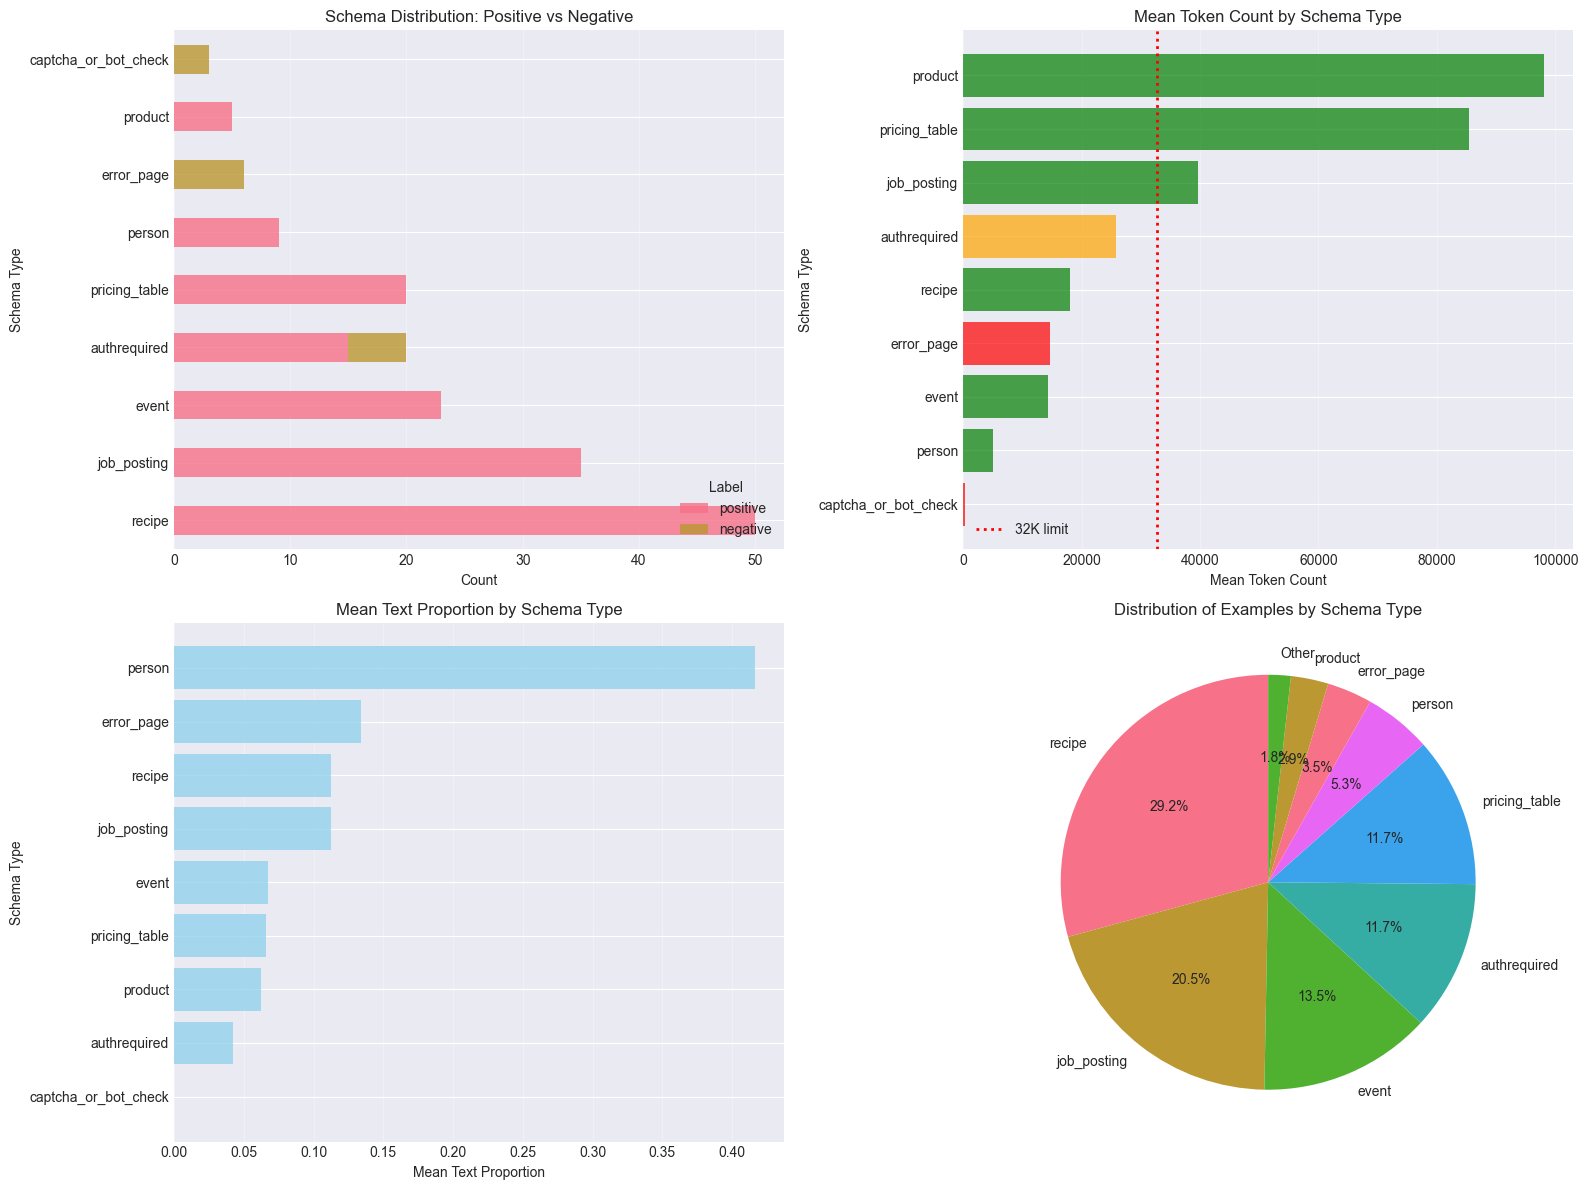


Color Legend for Mean Token Count chart:
  🟢 Green: Positive-only schemas
  🔴 Red: Negative-only schemas
  🟠 Orange: Shared schemas (in both candidates and negatives)


In [18]:
# Visualize comprehensive schema distribution
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Schema type counts (stacked bar: positive vs negative)
schema_counts_pivot = summary_table.set_index('schema_type')[['positive', 'negative']]
schema_counts_pivot.plot(kind='barh', stacked=True, ax=axes[0, 0], alpha=0.8)
axes[0, 0].set_xlabel('Count')
axes[0, 0].set_ylabel('Schema Type')
axes[0, 0].set_title('Schema Distribution: Positive vs Negative')
axes[0, 0].legend(title='Label', loc='lower right')
axes[0, 0].grid(True, alpha=0.3, axis='x')

# 2. Mean token count by schema type
summary_table_sorted = summary_table.sort_values('mean_tokens', ascending=True)
colors = ['green' if row['negative'] == 0 else 'red' if row['positive'] == 0 else 'orange' 
          for _, row in summary_table_sorted.iterrows()]
axes[0, 1].barh(summary_table_sorted['schema_type'], summary_table_sorted['mean_tokens'], color=colors, alpha=0.7)
axes[0, 1].axvline(32768, color='red', linestyle=':', linewidth=2, label='32K limit')
axes[0, 1].set_xlabel('Mean Token Count')
axes[0, 1].set_ylabel('Schema Type')
axes[0, 1].set_title('Mean Token Count by Schema Type')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='x')

# 3. Text proportion by schema type
summary_table_sorted_text = summary_table.sort_values('mean_text_prop', ascending=True)
axes[1, 0].barh(summary_table_sorted_text['schema_type'], summary_table_sorted_text['mean_text_prop'], 
                color='skyblue', alpha=0.7)
axes[1, 0].set_xlabel('Mean Text Proportion')
axes[1, 0].set_ylabel('Schema Type')
axes[1, 0].set_title('Mean Text Proportion by Schema Type')
axes[1, 0].grid(True, alpha=0.3, axis='x')

# 4. Pie chart of total examples by schema type
top_schemas = summary_table.nlargest(8, 'total')
other_count = summary_table.iloc[8:]['total'].sum() if len(summary_table) > 8 else 0
if other_count > 0:
    pie_data = pd.concat([top_schemas[['schema_type', 'total']], 
                          pd.DataFrame([{'schema_type': 'Other', 'total': other_count}])])
else:
    pie_data = top_schemas[['schema_type', 'total']]

axes[1, 1].pie(pie_data['total'], labels=pie_data['schema_type'], autopct='%1.1f%%', startangle=90)
axes[1, 1].set_title('Distribution of Examples by Schema Type')

plt.tight_layout()
plt.show()

# Print legend for bar colors
print('\nColor Legend for Mean Token Count chart:')
print('  🟢 Green: Positive-only schemas')
print('  🔴 Red: Negative-only schemas')
print('  🟠 Orange: Shared schemas (in both candidates and negatives)')

In [19]:
# Save positive analysis to CSV
positive_output = Path('../data/seeds/fragment_analysis_positive.csv')
df_positive.to_csv(positive_output, index=False)
print(f'Positive analysis saved to {positive_output}')

# Save negative analysis to CSV
negative_output = Path('../data/seeds/fragment_analysis_negative.csv')
df_negative.to_csv(negative_output, index=False)
print(f'Negative analysis saved to {negative_output}')

# Save combined analysis to CSV
combined_output = Path('../data/seeds/fragment_analysis_combined.csv')
df_combined.to_csv(combined_output, index=False)
print(f'Combined analysis saved to {combined_output}')

Positive analysis saved to ../data/seeds/fragment_analysis_positive.csv
Negative analysis saved to ../data/seeds/fragment_analysis_negative.csv
Combined analysis saved to ../data/seeds/fragment_analysis_combined.csv


## Final Summary

In [20]:
# Print final summary
print('\n' + '='*70)
print('FINAL SUMMARY')
print('='*70)

print('\n📊 DATASET OVERVIEW')
print(f'Total fragments: {len(df_combined)}')
print(f'  Positive examples: {len(df_positive)} ({len(df_positive)/len(df_combined)*100:.1f}%)')
print(f'  Negative examples: {len(df_negative)} ({len(df_negative)/len(df_combined)*100:.1f}%)')

print(f'\nSchema types:')
print(f'  Total unique types: {len(all_schema_types)}')
print(f'  Positive-only: {len([s for s in positive_schemas if s not in shared_schemas])}')
print(f'  Negative-only: {len([s for s in negative_schemas if s not in shared_schemas])}')
print(f'  Shared (both): {len(shared_schemas)}')

print('\n📈 POSITIVE EXAMPLES (Training Data)')
print(f'Token count stats (Qwen2.5-0.5B tokenizer):')
print(f'  Mean: {df_positive["html_tokens"].mean():,.0f} tokens')
print(f'  Median: {df_positive["html_tokens"].median():,.0f} tokens')
print(f'  Range: {df_positive["html_tokens"].min():,} - {df_positive["html_tokens"].max():,} tokens')

print(f'\nContext window fit:')
print(f'  Within 32K: {(df_positive["html_tokens"] <= 32768).sum()}/{len(df_positive)} ({(df_positive["html_tokens"] <= 32768).sum()/len(df_positive)*100:.1f}%)')
print(f'  In preferred range (<24K): {(df_positive["html_tokens"] <= 24576).sum()}/{len(df_positive)} ({(df_positive["html_tokens"] <= 24576).sum()/len(df_positive)*100:.1f}%)')

print(f'\nText proportion stats:')
print(f'  Mean: {df_positive["text_proportion"].mean():.3f}')
print(f'  Median: {df_positive["text_proportion"].median():.3f}')
print(f'  Range: {df_positive["text_proportion"].min():.3f} - {df_positive["text_proportion"].max():.3f}')

print(f'\nTop positive schema types:')
for schema_type, count in df_positive['schema_type'].value_counts().head(5).items():
    print(f'  {schema_type}: {count}')

print('\n❌ NEGATIVE EXAMPLES (Rejection Analysis)')
print(f'Token count stats:')
print(f'  Mean: {df_negative["html_tokens"].mean():,.0f} tokens')
print(f'  Median: {df_negative["html_tokens"].median():,.0f} tokens')

print(f'\nValidation scores:')
print(f'  Mean: {df_negative["validation_score"].mean():.3f}')
print(f'  Median: {df_negative["validation_score"].median():.3f}')

print(f'\nNegative schema types:')
for schema_type, count in df_negative['schema_type'].value_counts().items():
    print(f'  {schema_type}: {count}')

print(f'\nTop rejection reasons:')
for reason, count in df_negative['rejection_reason'].value_counts().head(3).items():
    print(f'  {reason}: {count}')

print('\n🔍 KEY INSIGHTS')
print('  • Negative schemas (error_page, authrequired, empty_shell) are valid training')
print('    examples for HTML→JSON extraction, not "bad" data')
print('  • Authrequired appears in both candidates and negatives - both are usable')
print('  • All schema types have distinct token/text characteristics')
print('  • Negative examples tend to have lower text proportion than positives')

print('\n' + '='*70)


FINAL SUMMARY

📊 DATASET OVERVIEW
Total fragments: 171
  Positive examples: 157 (91.8%)
  Negative examples: 14 (8.2%)

Schema types:
  Total unique types: 9
  Positive-only: 6
  Negative-only: 2
  Shared (both): 1

📈 POSITIVE EXAMPLES (Training Data)
Token count stats (Qwen2.5-0.5B tokenizer):
  Mean: 33,592 tokens
  Median: 18,057 tokens
  Range: 139 - 249,317 tokens

Context window fit:
  Within 32K: 109/157 (69.4%)
  In preferred range (<24K): 102/157 (65.0%)

Text proportion stats:
  Mean: 0.109
  Median: 0.080
  Range: 0.000 - 0.785

Top positive schema types:
  recipe: 50
  job_posting: 35
  event: 23
  pricing_table: 20
  authrequired: 15

❌ NEGATIVE EXAMPLES (Rejection Analysis)
Token count stats:
  Mean: 13,642 tokens
  Median: 3,532 tokens

Validation scores:
  Mean: 0.000
  Median: 0.000

Negative schema types:
  error_page: 6
  authrequired: 5
  captcha_or_bot_check: 3

Top rejection reasons:
  Detected error_page: 3/12 negative patterns matched: 4
  Detected auth_require